In [26]:
import os
import time
import boto3

runtime = boto3.client(service_name='runtime.sagemaker')
BUCKET = 'dtong-cv-jumpstarter-workshop'
S3_PREFIX = '/ground-truth-lab/images'

IMGS_S3URI = 's3://'+BUCKET+S3_PREFIX
print(IMGS_S3URI)

s3://dtong-cv-jumpstarter-workshop/ground-truth-lab/images


In [12]:
print("aws s3 sync "+IMGS_S3URI+" ./images")

aws s3 sync s3://dtong-cv-jumpstarter-workshop/ground-truth-lab/images ./images


In [13]:
start = time.time()

os.system("aws s3 sync "+IMGS_S3URI+" ./images")

end = time.time()
print("Images copied to local directory in "+str(int(end - start))+" seconds.")

Images copied to local directory in 0 seconds.


In [34]:
from sagemaker.predictor import RealTimePredictor, npy_serializer, json_deserializer

#RT_ENDPOINT_NAME = '<<REPLACE WITH THE NAME OF YOUR ENDPOINT>>'
RT_ENDPOINT_NAME = 'dtong-cv-workshop-smssd-rt-ep'
        
od_endpoint = RealTimePredictor(endpoint=RT_ENDPOINT_NAME,
                                content_type='image/jpeg',
                                deserializer= json_deserializer)

In [39]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json

OBJECT_CATEGORIES = ['bird']

def visualize_detection(img_file, dets, classes=[], thresh=0.6):

        img = mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width  = img.shape[1]
        colors = dict()
        num_detections = 0
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            num_detections += 1
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id], linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            print('{},{}'.format(class_name,score))
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')

        print('Number of detections: ' + str(num_detections))
        plt.show()
        
def show_bird_prediction(filename, ep, thresh=0.40):
    b = ''
    with open(filename, 'rb') as image:
        f = image.read()
        b = bytearray(f)
    endpoint_response = runtime.invoke_endpoint(EndpointName=ep,
                                           ContentType='image/jpeg',
                                           Body=b)
    results = endpoint_response['Body'].read()
    detections = json.loads(results)
    visualize_detection(filename, detections['prediction'], OBJECT_CATEGORIES, thresh)

bird,0.6403394341468811
Number of detections: 1


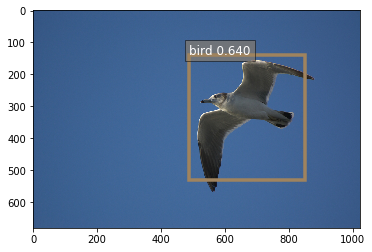

bird,0.45743638277053833
bird,0.41432633996009827
Number of detections: 2


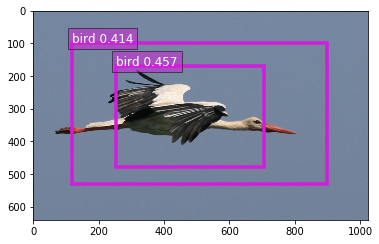

Number of detections: 0


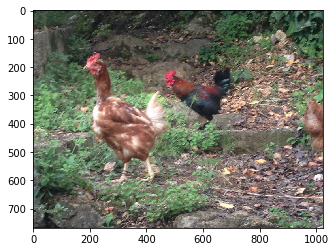

Number of detections: 0


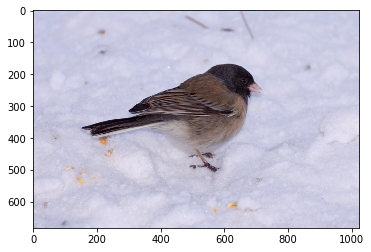

bird,0.4045673608779907
Number of detections: 1


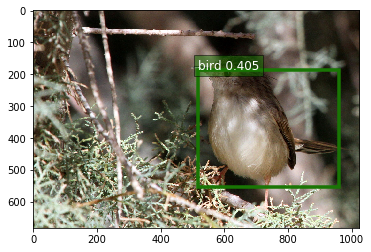

Number of detections: 0


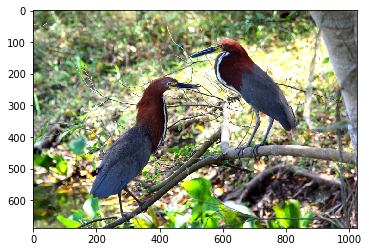

bird,0.4042742848396301
Number of detections: 1


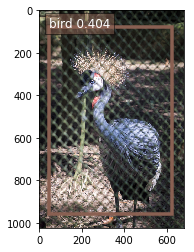

Number of detections: 0


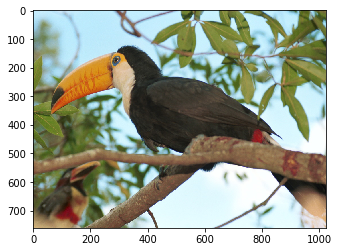

bird,0.4467090368270874
Number of detections: 1


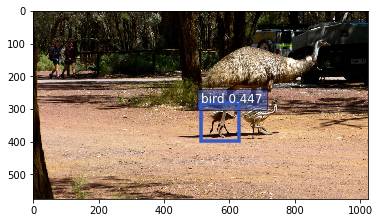

bird,0.47399020195007324
Number of detections: 1


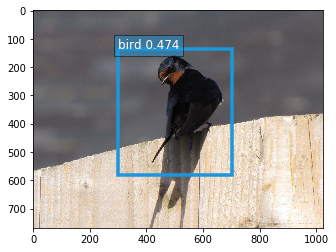

In [54]:
from os import walk

img_dir = './images'
for (dirpath, dirnames, filenames) in walk(img_dir):
    for f in filenames :
        show_bird_prediction(os.path.join(img_dir,f), od_endpoint.endpoint)